In [ ]:
"""This is 2 layer neural network that classifies the MNIST dataset. I have used sigmoid as activation function and the ouput layer using softmax classifier 
causing the loss rate to be loss and the accuracy to be high. The gradient descent used is mini-batch. 
"""
!pip install mnist
import mnist
import numpy as np
import matplotlib.pyplot as plt


Original training image size: (60000, 28, 28)
Flatten training image size: (60000, 784)
Flatten testing image size: (10000, 784)
Min Training image: 0.01
Max training image: 1.0
1
(60000, 784)


(-0.5, 27.5, 27.5, -0.5)

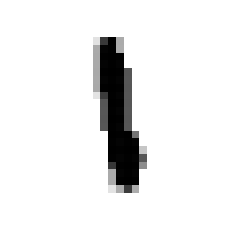

In [ ]:
train_images=mnist.train_images() #[60000,28,28]
train_labels_new=mnist.train_labels() #[60000]
test_images=mnist.test_images()   #[10000,28,28]
test_labels_new=mnist.test_labels()   #[10000]

D=784 #Dimensionality
K=10 #[0,1,2,3,..,9] labels

print("Original training image size:",train_images.shape) #In order to plot the image we need this original size as flattened size can't be plotted
#Flattening the images. Each 28*28 images into a 28*28=784 dimensional vector
train_images=train_images.reshape((-1,784)) #3-D to 2-D Rows are not specified but columns are 784
test_images=test_images.reshape((-1,784)) 
print("Flatten training image size:",train_images.shape)
print("Flatten testing image size:",test_images.shape)

#Normalizing the pixel value from [0,255] to [0.01,1]
fac=0.99/255
train_images= np.asfarray(train_images[:,:])*fac + 0.01
test_images= np.asfarray(test_images[:,:])*fac + 0.01

print("Min Training image:",train_images.min())
print("Max training image:",train_images.max())
"""
#Normalizing the data to keep the gradient manageable. Normize the pixel value from[0,255] to [-0.5,0.5]
#print(train_images[2002])
train_images=(train_images/255)-0.5
#print(train_images[2002])
test_images=(test_images/255)-0.5
"""
#print(train_labels_new)
print(train_labels_new[200])
print(train_images.shape)
plt.imshow(train_images[200].reshape((28,28)),cmap=plt.cm.binary,interpolation="nearest")
plt.axis("off")


In [ ]:
#One hot encoding 

digits=10
num_labels=train_labels_new.shape[0] #[60000]
num_test_labels=test_labels_new.shape[0] #[10000]

print("Before one hot encoding:",train_labels_new)
print("Training label shape before one hot encoding:",train_labels_new.shape)
print("Testing label shape before one hot encoding:",test_labels_new.shape)

train_labels=np.eye(digits)[train_labels_new.astype('int32')]
test_labels=np.eye(digits)[test_labels_new.astype("int32")]

train_labels=train_labels.reshape(num_labels,digits)
test_labels=test_labels.reshape(num_test_labels,digits)
print("Training labels after one hot encoding:",train_labels.shape)
print("Testing labels after one hot encoding:",test_labels.shape)
print("After one hot encoding:\n",train_labels)

print(test_labels_new[20])
print(test_labels[20,:])
print(np.eye(digits)[test_labels_new.astype('int32')[20]])

Before one hot encoding: [5 0 4 ... 5 6 8]
Training label shape before one hot encoding: (60000,)
Testing label shape before one hot encoding: (10000,)
Training labels after one hot encoding: (60000, 10)
Testing labels after one hot encoding: (10000, 10)
After one hot encoding:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
np.random.seed(300) #the same random number repeats for 300 times

num_examples=train_images.shape[0] #60000
num_labels=train_labels.shape[0] #60000

#hyperparameters
reg=1e-3 #regularization strength lambda
step_size=4 #learning rate 
epoch=30
mini_batch_size=128
batches=num_examples//mini_batch_size #floor division

#Neural Network architecture
input_layer= 784
hidden_layer= 300
output_layer= 10

#Parameters initialization
parameters={
          "W1":np.random.randn(input_layer,hidden_layer)*np.sqrt(2/input_layer), #[784,300]
          'b1':np.zeros((1,hidden_layer)), #[1,300]
          "W2":np.random.randn(hidden_layer,output_layer)*np.sqrt(2/hidden_layer), #[300,10]
          "b2":np.zeros((1,output_layer)) #[1,10]
            }
#print(parameters["W1"].shape)

def sigmoid(x):
  s = 1. / (1. + np.exp(-x))
  return s
#Feedforward implementation
"""In the previous problem for the output layer is used score function,hence couldnot use the one hot encoding.
In this for the output layer we use the softmax function where the score functions are exponentiated and normalized 
probability used which will give us a intuitive data.
"""
def feed_forward(X,parameters):
  activations={}

  activations["Z1"]=np.dot(X,parameters["W1"])+parameters["b1"] #[60000,784]*[784,300]=[60000,300]
  activations["A1"]=sigmoid(activations["Z1"]) #[60000,300]
  activations["Z2"]=np.dot(activations["A1"],parameters["W2"])+parameters["b2"] #[60000,300]*[300,10]=[60000,10] scores for the output layers
  
  exp_scores=np.exp(activations["Z2"])
  exp_sum=np.sum(exp_scores,axis=1,keepdims=True) #exp_sum=[60000,1] without keepdimension its[60000,] and we then can't do dot product
  activations["A2"]=exp_scores/exp_sum #[60000,10]
  #print(activations["A2"].shape)
  return activations
def loss(Y,output):
  Loss_sum=np.sum(np.multiply(Y,np.log(output)))
  data_loss= -(1/num_labels) * Loss_sum

  #reg_loss= 0.5*reg*np.sum(parameters["W1"]*parameters["W1"]) + 0.5*reg*np.sum(parameters["W2"]*parameters["W2"])

  #loss=data_loss + reg_loss

  return data_loss

def backpropagation(X,Y,parameters,activations):

  dZ2=activations["A2"]-Y #[60000,10]
  #print(dZ2[100,:])
  dW2=(1/mini_batch)*np.dot(activations["A1"].T,dZ2) #[300,10]
  db2=(1/mini_batch)*np.sum(dZ2,axis=0,keepdims=True)#[1,10]
  dA1=np.dot(dZ2,parameters["W2"].T) #[60000,300]
  dZ1=dA1 * sigmoid(activations["Z1"]) * (1-sigmoid(activations["Z1"])) #[60000,300]
  dW1=(1/mini_batch)*np.dot(X.T,dZ1)#[784,300]
  db1=(1/mini_batch)*np.sum(dZ1,axis=0,keepdims=True)#[1,300]

  gradients={
      "dW1":dW1,
      "db1":db1,
      "dW2":dW2,
      "db2":db2
            }
  return gradients

#Training the data with mini-batch gradient descent
for i in range(epoch):  
  

#shuffling the training set
  permutation = np.random.permutation(num_examples) #the sequence is altered randomly
  train_images_shuffled = train_images[permutation,:]
  train_labels_shuffled = train_labels[permutation,:]


  for j in range(batches):
    begin=j*mini_batch_size
    end=min(begin+mini_batch_size,num_examples-1)
    X=train_images_shuffled[begin:end,:]
    Y=train_labels_shuffled[begin:end]
    mini_batch = end - begin

    activations=feed_forward(X,parameters)
    gradients=backpropagation(X,Y,parameters,activations)
                                                                                                                                                                                                      
    parameters["W1"]+= -step_size*gradients["dW1"]
    parameters["b1"]+= -step_size*gradients["db1"]
    parameters["W2"]+= -step_size*gradients["dW2"]
    parameters["b2"]+= -step_size*gradients["db2"]
  
  activations=feed_forward(train_images,parameters)
  train_loss=loss(train_labels,activations["A2"])

  activations=feed_forward(test_images,parameters)
  test_loss=loss(test_labels,activations["A2"])
  print("Epoch{}: training cost= {} and testing loss={} ".format(i,train_loss,test_loss))

print("Done")





Epoch0: training cost= 0.2353732342481926 and testing loss=0.039565654655020266 
Epoch1: training cost= 0.17550297496158399 and testing loss=0.0306824635652809 
Epoch2: training cost= 0.15402047166823332 and testing loss=0.02838897378744749 
Epoch3: training cost= 0.1509742962156808 and testing loss=0.029811878792046456 
Epoch4: training cost= 0.12006342184134833 and testing loss=0.024801344800814955 
Epoch5: training cost= 0.11858124048219774 and testing loss=0.025008602451170765 
Epoch6: training cost= 0.13431273335456861 and testing loss=0.02757513053231888 
Epoch7: training cost= 0.09995059119637906 and testing loss=0.023618414787580855 
Epoch8: training cost= 0.10865535027484804 and testing loss=0.02569616925689162 
Epoch9: training cost= 0.09721743594556893 and testing loss=0.023994455750857773 
Epoch10: training cost= 0.08526813886803757 and testing loss=0.02335808162084288 
Epoch11: training cost= 0.07373117303301113 and testing loss=0.021408733971826136 
Epoch12: training cost

In [ ]:
activations=feed_forward(train_images,parameters)
predicted_class = np.argmax(activations["A2"],axis=1)
print(predicted_class[800])
predicted_class_encoded=np.eye(digits)[predicted_class.astype('int32')]
print(predicted_class_encoded[800,:])
print("training accuracy:%.6f"%(np.mean(predicted_class_encoded==train_labels)))

9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
training accuracy:0.998007


In [ ]:
activations=feed_forward(test_images,parameters)
predicted_class = np.argmax(activations["A2"],axis=1)
print(predicted_class[800])

predicted_class_encoded=np.eye(digits)[predicted_class.astype('int32')]
print(predicted_class_encoded[800,:])
print(test_labels[800,:])
print("testing accuracy:%.5f"%(np.mean(predicted_class_encoded==test_labels)))

8
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
testing accuracy:0.99324
